# OPIM 609 Final Assignment
### October 10th, 2022
### SAXA X
Daniel Behrns, Adriana Cailao, Matthew Nicoletta, Adrian Ott, Jeannie Sprangle

##### Contents <a id = 'top'></a>
1. [Preparation](#1)
    1. [Packages](#1a)
    2. [Functions](#1b)
    3. [Load Data](#1c)
2. [Explore](#2)
    1. [Hotels](#2a)
    2. [Reviews](#2b)
    3. [Reviewers](#2c)
3. [Clean](#3)
    1. [Remove non-hotel reviews](#3a)
    2. [Split dataframs](#3b)
3. [Term Frequency](#4)
    1. [Good reviews](#4a)
    2. [Bad reviews](#4b)
4. [Topic Modeling](#5)
    1. [Good reviews](#5a)
    2. [Bad reviews](#5b)
5. [Wordclouds](#6)
    1. [Good reviews](#6a)
    2. [Bad reviews](#6b)

## **Preparation**<a id='1'></a>

### Packages <a id = '1a'></a>

In [1]:
# Load Packages
import pandas as pd
import numpy as np
import sqlite3
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import warnings
warnings.filterwarnings("ignore")

/home/fresh/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
# Display options
#pd.set_option('display.max_colwidth', -1)

#### Functions <a id = '1b'></a>

In [3]:
# Function removes punctuation and non-letter characters from text
def clean_text(t):
    import re
    
    t = t.lower()
    t = re.sub("@[A-Za-z0-9]+", "", t) # remove handles
    t = re.sub("#[A-Za-z0-9]+", "", t) # remove hashtags
    t = re.sub(r"http\S+", "", t)      # remove links (anything that doesn't have a space after http)
    t = re.sub(r"www.\S+", "", t)      # remove links
    t = re.sub("[()!?]", "", t)        # remove punctuation
    t = re.sub("'", "", t)             # remove apostrophes, replace with no space
    t = re.sub("\[.*?\]", "", t)       # remove puncutation
    t = re.sub("[^a-z]", " ", t)
    return t

In [4]:
# Function vectorizes specified text and returns most frequent ngrams in specified range
def get_ngrams(text, ngram_from = 1, ngram_to = 4, n = None, max_features = 20000):
    
    vec = CountVectorizer(ngram_range = (ngram_from, ngram_to),
                          max_features = max_features,
                          stop_words = "english").fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    
    return words_freq[:n]

In [5]:
# Isolate nouns in a corpus
def nouns(text):
    import nltk
    from nltk.corpus import stopwords
    import string
    from nltk import word_tokenize, pos_tag
    
    #Given a string of text, tokenize the text and pull out only the nouns.
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)]
    return ' '.join(all_nouns)

In [6]:
# Topic modeling function - applies LDA algorithm to text with number of topics specified, returns interactive visualization
def model_topics(df, topics):

    # Instantiate vectorizer
    v = CountVectorizer(stop_words = sw,
                        min_df = 0.2,
                        max_df = 0.8)

    # Vectorize to create dtm
    dtm = v.fit_transform(df)    
    
    lda = LatentDirichletAllocation(n_components = topics,
                                    random_state = 987)
    topic_model = lda.fit_transform(dtm)
    lda_viz = pyLDAvis.sklearn.prepare(lda_model = lda,
                                       dtm = dtm,
                                       vectorizer = v)
    return pyLDAvis.display(lda_viz)

#### Load data <a id = '1c'></a>

In [7]:
# Define connection to data set db
con = sqlite3.connect("yelp_hotel.db")

# Create pandas data frames from the three tables in the db
reviews = pd.read_sql_query("SELECT * from review;", con)
hotel = pd.read_sql_query("SELECT * from hotel;", con)
reviewer = pd.read_sql_query("SELECT * from reviewer;", con)

# Close the connection
con.close()

Let's look at the hotel table. We can see there are 13 columns with over 283K unique hotels. But looking at the categories, most of these locations are not actually categorized as hotels. Let's see how many are left if we limit the venues to those that are actually hotels.

In [8]:
hotel.shape

(283086, 13)

In [9]:
# We can see that many/most venues in the hotel table are not tagged as hotels
list(hotel["categories"])

['Event Planning & Services, Hotels, Hotels & Travel',
 'Event Planning & Services, Hotels, Hotels & Travel',
 'Event Planning & Services, Hotels, Hotels & Travel',
 'Event Planning & Services, Hotels, Hotels & Travel',
 'Event Planning & Services, Hotels, Hotels & Travel',
 'Event Planning & Services, Hotels, Hotels & Travel, Venues & Event Spaces',
 'Event Planning & Services, Hotels, Hotels & Travel',
 'Event Planning & Services, Hotels, Hotels & Travel',
 'Event Planning & Services, Hotels, Hotels & Travel',
 'Event Planning & Services, Hotels, Hotels & Travel, Venues & Event Spaces',
 'Event Planning & Services, Hotels, Hotels & Travel',
 'Event Planning & Services, Hotels, Hotels & Travel',
 'Event Planning & Services, Hotels, Hotels & Travel',
 'Event Planning & Services, Hotels, Hotels & Travel',
 'Event Planning & Services, Hotels, Hotels & Travel',
 'Event Planning & Services, Hotels, Hotels & Travel',
 'Event Planning & Services, Hotels, Hotels & Travel, Bed & Breakfast',
 '

In [10]:
# These are venue names in the hotel table that do not contain the word 'hotel'. Although many of these are still
# Actually hotels, many more are not. Scroll through and see Starbucks locations, banks, museums, grocery stores, etc.
list(hotel[-hotel["name"].str.contains("Hotel")]["name"])

['Old Chicago Inn',
 'Inn At Lincoln Park',
 'Hilton Suites Chicago',
 'Chicago Travelodge Downtown',
 'Hilton Garden Inn Chicago Downtown_Magnificent Mile',
 'Embassy Suites Chicago Downtown Lakefront',
 'Hampton Inn and Suites Chicago',
 'Public Chicago',
 'Doubletree Magnificent Mile',
 'Courtyard Marriott Magnificent Mile',
 'The Westin Michigan Avenue Chicago',
 'Red Roof Inn',
 'Fairmont Chicago',
 'Best Western River North Chicago',
 'Hyatt Regency McCormick Place',
 'Best Western Grant Park',
 'W Chicago - City Center',
 'Radisson Blu Aqua',
 'Holiday Inn',
 'InterContinental Chicago',
 'Chicago Marriott Downtown Magnificent Mile',
 'Hilton Chicago',
 'Embassy Suites Chicago Downtown',
 'W Chicago - Lakeshore',
 'Essex Inn',
 'Hyatt Regency Chicago',
 'Best Western Hawthorne Terrace',
 'La Quinta Inn and Suites Chicago Downtown',
 'The Westin Chicago River North',
 'Crowne Plaza Metro',
 "Heart O' Chicago Motel",
 'Chicago Marriott at Medical District_UIC',
 'Ramada',
 'The Pea

In [11]:
# Number of venues actually categorized as hotels
hotel[hotel["categories"].str.contains("Hotels, ")]["categories"].count()

10097

The following code uses a SQL style merge/join to add hotel name and category information to the reviews dataframe indexing on the hotelID field. We are then able to use the categoies field to filter out non-hotel reviews.

In [12]:
# Subset hotel df before combining with reviews. We are removing average review, which we will calculate ourselves
hotel_subset = hotel.drop('rating', axis = 1)

# Join reviews and hotels dfs on hotelID keeping all reviews and assigning hotel info to them
reviews = pd.merge(reviews, hotel_subset, how = 'left', on = 'hotelID')

# Subset data to only reviews about hotels
reviews = reviews[reviews["categories"].str.contains("Hotels,") == True]

In [13]:
reviews.shape

(31723, 21)

Now that we have filtered the review dataset down to approximately 32K reviews categorized as hotels, let's get a sense of how many of these reviewes have been flagged as fraudulent and/or violating the Yelp terms of service.

In [14]:
# Percentage of reviews flagged in each category
reviews.groupby(["flagged"])["flagged"].count() / reviews["flagged"].count() * 100

flagged
N     16.007313
NR    55.536992
Y      2.458784
YR    25.996911
Name: flagged, dtype: float64

We will remove the ~ 28% of reviewes flagged as fraudulent (Y/YR) and verify that only N/NR reviews remain.

In [15]:
reviews = reviews.loc[reviews["flagged"].isin(["N", "NR"])]

In [16]:
# Reviewers df
reviews.groupby(["flagged"])["flagged"].count() / reviews["flagged"].count() * 100

flagged
N     22.373987
NR    77.626013
Name: flagged, dtype: float64

In [17]:
reviews.shape

(22696, 21)

This data set will be the basis for all further evaluation. To recap, we filtered out any reviews that were for venues not categorized explicitly as a hotel and removed any review flagged as fraudulent. The remaining dataset has all the fields from the data source review table and joined to each review is data from the hotel table.

Next, we will clean the text from reviews using a series of regular expressions to remove non-letter characters and convert to lowercase. This will make it easier for us to perform text analysis. We will also subset our reviews data frame into two smaller data frames for good reviews (ratings of 4/5) and bad reviews (ratings 1/2). For the purposes of our analysis, we consider reviews with a rating of 3 to be neutral.

In [18]:
# Cast text as category and clean text for all reviews
reviews["cleanText"] = reviews["reviewContent"].astype("category")
reviews["cleanText"] = reviews["cleanText"].apply(clean_text)

---
### Segment by good/bad hotels
We experimented with different methods of categorizing the reviews as good or bad in order to perform textual analysis. At first, we simply divided the reviews into two pools--any review that was 4/5 stars was good and any review that was 1/2 stars was bad. While this method was somewhat effective, we found that it failed to account for the fact that good (bad) reviews at very good (bad) hotels have little in common with good (bad) reviews at bad (good) hotels.

So we took at two-tier appraoch to dividing our reviews into good and bad pools for further analysis. First, we calculated the average rating for all of the hotels in our dataset. This is different than the average rating in the original data source hotels table because those averages included reviews that we removed (those flagged as fraudulent, for example). Then we divided the hotels into two groups base on our calculated average, using 3 as the dividing line. 

The second step took the best reviews of the above average hotels--those with 4/5 ratings and the worst reviews of the below-average hotels--those with 2/3 ratings. We created two data frames, as you can see below.

In [19]:
hotel_avg = reviews.groupby(["hotelID"]).agg(avg_rating = ("rating", "mean")).reset_index()

In [20]:
reviews2 = pd.merge(reviews, hotel_avg, how = 'left', on = 'hotelID')


In [21]:
# Create dfs for bad reviews (rating < 3) and good reviews (rating > 3)
good_hotels = reviews2[reviews2["avg_rating"] > 3]
bad_hotels = reviews2[reviews2["avg_rating"] < 3]


In [22]:
# Create dfs for good hotels good reviews and bad hotels bad reviews
good_hotels_rev = good_hotels[good_hotels["rating"] > 3]
bad_hotels_rev = bad_hotels[bad_hotels["rating"] < 3]

In [23]:
good_hotels_rev.shape

(12800, 23)

In [24]:
bad_hotels_rev.shape

(2227, 23)

### Word Clouds <a id = '6'></a>
It can be helpful to visualize the corpus in a word cloud where the size of the word is determined by the frequency in which it occurs. Here are word clouds for both the best reviews and the worst reviews.

In [25]:
# All reviews
good_text = " ".join(review for review in good_hotels_rev["cleanText"])
bad_text = " ".join(review for review in bad_hotels_rev["cleanText"])

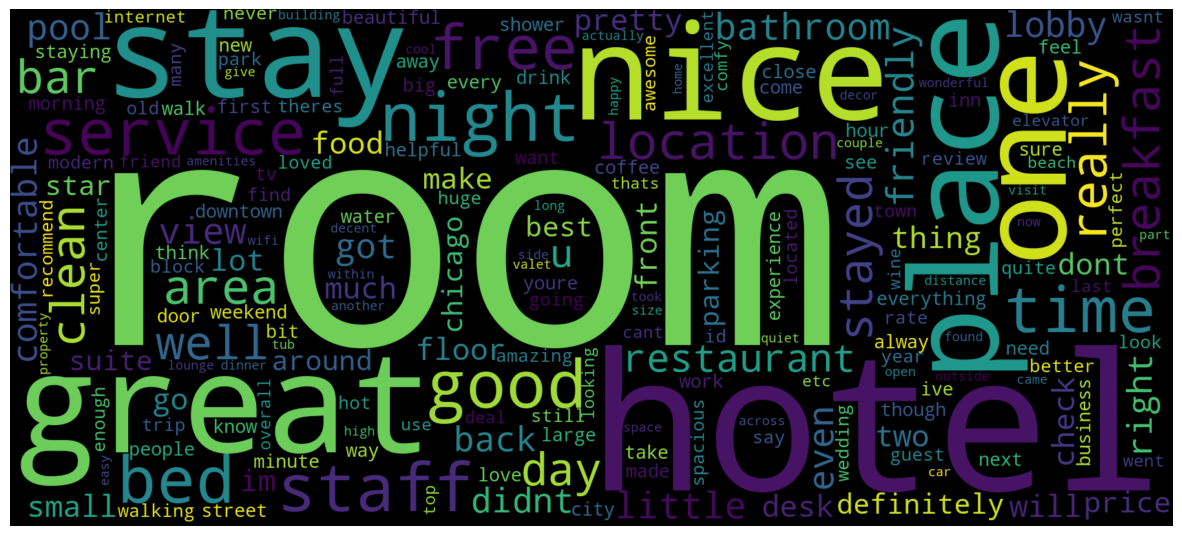

In [26]:
# Define a word cloud from the pos text string
wordcloud_good = WordCloud(collocations = False, width = 1800, height = 800).generate(good_text)

# Plot the word cloud
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud_good, interpolation = "bilinear")
plt.axis("off")
plt.show()

#### Good Reviews <a id = '6a'></a>

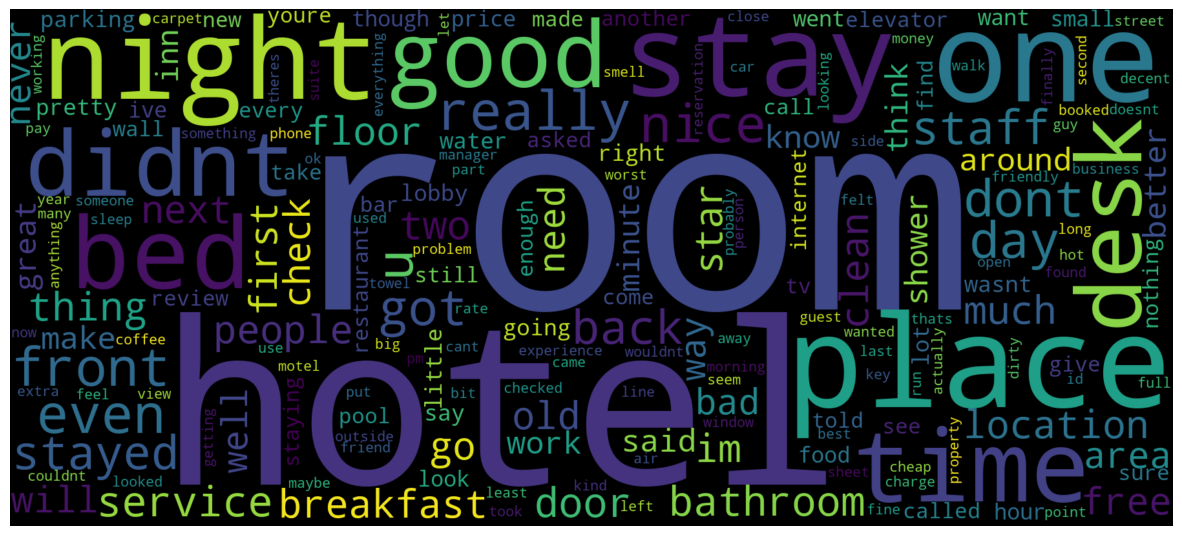

In [27]:
# Define a word cloud from the pos text string
wordcloud_bad = WordCloud(collocations = False, width = 1800, height = 800).generate(bad_text)

# Plot the word cloud
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud_bad, interpolation = "bilinear")
plt.axis("off")
plt.show()

As we can see from the word clouds, there is quite a bit of overlap in the most frequently used words, regardless of whether the reviews was good or bad. For example, hotel and room seem to be the most occuring terms. Place, stay, nice, and other terms also occur frequently. While this is a great starting point, there is little to help us understand the context or sentiment associated with these terms. 

[Back to Top](#top)

## **Topic Modeling** <a id = '2'></a>
We used the LDA algorithm to perform topic modeling on our good/bad review data frames. Although we experimented with the number of topics to model for each, we found that 4 topics seems appropriate in both cases. We want to see little overlap in the topics, which we have here. Although higher numbers of topics can also achieve plots with little overlap, the interpretability of these additional topics becomes difficult. We offer a brief interpretation of the topics for good/bad reviews below.

In [28]:
# Import and read in stopwords
from nltk.corpus import stopwords
sw = stopwords.words("english")

# Add additional stopwords to stopword list to use when vectorizing
sw.extend(["hotel"])

In [29]:
# Instantiate vectorizer
v = CountVectorizer(stop_words = sw,
                   min_df = 0.2,
                   max_df = 0.8)

#### Good Reviews <a id = '5a'></a>

In [30]:
model_topics(good_hotels_rev["cleanText"], 4)

- Topic 1 is about clean rooms and nice staff.
- Topic 2 emphasizes great (room?) service 
- Topic 3 is centered on the place
- Topic 4 seems to be about free breakfast

In [31]:
model_topics(bad_hotels_rev["cleanText"], 4)

- Topic 1 is clearly cented on rooms, and includes some negative sentiment words
- Topic 2 seems to highlight interactions with the front desk staff
- Topic 3, similar to the good reviews, emphasizes place/location
- Topic 4 is perhaps a little more difficult to interpret, but it seems to be discussion of whether people would return for another stay

## **Term Frequency** <a id = '4'></a>
Using our topic modeling as a good general overview of the most important hotel features discussed in these reviews, we took a deeper dive by looking at the most frequent unigram, bigram, and trigrams in each review pool. The below tables show the top 20 of each and their frequencies. 

#### Good Reviews <a id = '4a'></a>

In [32]:
# Top 10 unigrams
good_grams = get_ngrams(good_hotels_rev["cleanText"], 1, 1, 20)
goodgrams_pr = pd.DataFrame(good_grams)
goodgrams_pr.columns=["Unigram", "U_Freq"]

# Top 10 bigrams
good_grams = get_ngrams(good_hotels_rev["cleanText"], 2, 2, 20)
df = pd.DataFrame(good_grams)
df.columns = ["Bigram", "Bi_Freq"]

goodgrams_pr = goodgrams_pr.join(df["Bigram"])
goodgrams_pr = goodgrams_pr.join(df["Bi_Freq"])

# Top 10 Trigrams
good_grams = get_ngrams(good_hotels_rev["cleanText"], 3, 3, 20)
df = pd.DataFrame(good_grams)
df.columns = ["Trigram", "Tri_Freq"]

goodgrams_pr = goodgrams_pr.join(df["Trigram"])
goodgrams_pr = goodgrams_pr.join(df["Tri_Freq"])

goodgrams_pr

,Unigram,U_Freq,Bigram,Bi_Freq,Trigram,Tri_Freq
0,hotel,17107,room service,964,flat screen tv,337
1,room,16240,walking distance,940,free wi fi,330
2,great,9094,great location,844,king size bed,170
3,nice,8136,staff friendly,750,pool hot tub,166
4,stay,7329,place stay,658,staff friendly helpful,166
5,rooms,6656,flat screen,615,great place stay,148
6,place,6080,ive stayed,599,hotel great location,130
7,like,5600,free wifi,559,staff super friendly,108
8,good,5541,definitely stay,518,flat screen tvs,108
9,staff,5455,wi fi,517,room th floor,105


We can see that some of the features most associated with good rooms are cleanliness and the presence of a flat screen tv, free wifi, and a king size bed. In terms of location, walking distance (presumably to nearby attractions) seemed to be a key feature. Helpful, friendly staff were frequently mentioned as well. For food, customers seemed to appreciate room service and a free breakfast.

In [33]:
# Top 10 unigrams
bad_grams = get_ngrams(bad_hotels_rev["cleanText"], 1, 1, 20)
badgrams_pr = pd.DataFrame(bad_grams)
badgrams_pr.columns=["Unigram", "U_Freq"]

# Top 10 bigrams
bad_grams = get_ngrams(bad_hotels_rev["cleanText"], 2, 2, 20)
df = pd.DataFrame(bad_grams)
df.columns = ["Bigram", "Bi_Freq"]

badgrams_pr = badgrams_pr.join(df["Bigram"])
badgrams_pr = badgrams_pr.join(df["Bi_Freq"])

# Top 10 Trigrams
bad_grams = get_ngrams(bad_hotels_rev["cleanText"], 3, 3, 20)
df = pd.DataFrame(bad_grams)
df.columns = ["Trigram", "Tri_Freq"]

badgrams_pr = badgrams_pr.join(df["Trigram"])
badgrams_pr = badgrams_pr.join(df["Tri_Freq"])

badgrams_pr

,Unigram,U_Freq,Bigram,Bi_Freq,Trigram,Tri_Freq
0,room,3742,holiday inn,135,holiday inn express,41
1,hotel,2848,ive stayed,132,free wi fi,36
2,place,1609,looked like,111,non smoking room,36
3,like,1442,room service,108,flat screen tv,18
4,stay,1338,wi fi,101,hilton garden inn,18
5,just,1272,hotel room,100,congress plaza hotel,17
6,night,1142,parking lot,97,room smelled like,17
7,rooms,1139,felt like,84,pool hot tub,16
8,good,862,customer service,81,worst hotel stayed,13
9,didnt,846,dont know,80,room th floor,13


In the bad reviews, we see terms related to rooms that indicate they were not clean, had unpleasant odors, or were rundown or dated. Free continental breakfast and room service are again mentioned, emphasizing that these ancillary food-related service experiences are important to customers. Even in bad reviews, we see that interactions with friendly staff are important, but contrasting with the good reviews, friendly only gets you so far--helpful staff seem to significantly improve the guest experience. 

[Back to Top](#top)

In [34]:
list(reviews2)

['date',
 'reviewID',
 'reviewerID',
 'reviewContent',
 'rating',
 'usefulCount',
 'coolCount',
 'funnyCount',
 'flagged',
 'hotelID',
 'name',
 'location',
 'reviewCount',
 'categories',
 'address',
 'AcceptsCreditCards',
 'PriceRange',
 'WiFi',
 'webSite',
 'phoneNumber',
 'filReviewCount',
 'cleanText',
 'avg_rating']

In [35]:
test = reviews2.groupby("name").agg(rating = ("avg_rating", "mean"), 
                                    reviews = ("reviewCount", "count")).sort_values(by = ["rating", "reviews"], ascending = False)

In [36]:
test.head(50)

,rating,reviews
name,,
Elysian Hotel,5.0,10
Charleston Place Hotel,5.0,5
Four Seasons Hotel Atlanta,5.0,5
Four Seasons Hotel Denver,5.0,5
Loden Hotel,5.0,5
Calistoga Ranch,5.0,4
Farmhouse Inn & Restaurant,5.0,4
Hyatt Regency Scottsdale Resort & Spa at Gainey Ranch,5.0,4
Park Hyatt Toronto,5.0,4


In [37]:
pd.set_option('display.max_colwidth', -1)
reviews2[(reviews2["cleanText"].str.contains("king") & (reviews2["avg_rating"] > 4))]["cleanText"]

70       stayed in the motel part of the hotel  but attended a marriage ceremony and reception in the main building  the motel is a real throwback  with multiple versions of patterned wallpaper  bright colored bedspreads  and drapes all mixed in with a combination of carpet and contrasting tile  its a good thing i could give a s  t about decorating  the bed was comfortable and clean  and overall  the place is very nicely kept  bathroom is tight for two really  its tight for one  but a nice  hot shower  the accommodations for the marriage ceremony and reception were top notch  and everything from the bartenders to the hors douevres were excellent  and the dinner was incredible    not sure ive ever seen a kitchen send out this much food    and complicated food beef wellington  no less    and have it come out hot  crispy and delicious  kudos to all for being spot on tip  dont forget to ask for the wifi password when checking in    and the wifi password expires in the middle of the night  

In [38]:
hotel_avg = reviews.groupby(["hotelID"]).agg(avg_rating = ("rating", "mean")).reset_index()

In [39]:
hotel_avg.head()

,hotelID,avg_rating
0,--0Rizt5ryqiOqxgtyJk3Q,4.000000
1,-0-R267zNIQDPI9rxJlprQ,5.000000
2,-0jIbZ6pBDSqb-Q1CzhBmw,3.000000
3,-0qht1roIqleKiQkBLDkbw,3.333333
4,-1Qz4kKJcEmJV1FhT3u1zQ,2.000000


/home/fresh/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/fresh/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/fresh/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/fresh/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/fresh/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: 